# Regression

We want to predict fuel efficiency (MPG) from vehicles produced in the late 70s - early 80s.

In [21]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


In [33]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/waydegg/.keras/datasets/auto-mpg.data'

In [34]:
column_names = ["MPG", "Cylinders", "Displacement", "Horesepower", "Weight", "Acceleration", "Model Year", "Origin"]
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horesepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [35]:
# Remove na values
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horesepower     6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [36]:
dataset = dataset.dropna()

In [37]:
# one-hot encode "Origin" column as it's categorical and not continous
origin = dataset.pop("Origin")

dataset["USA"] = (origin == 1)*1.0
dataset["Europe"] = (origin == 2)*1.0
dataset["Japan"] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horesepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [38]:
# Split data into training and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

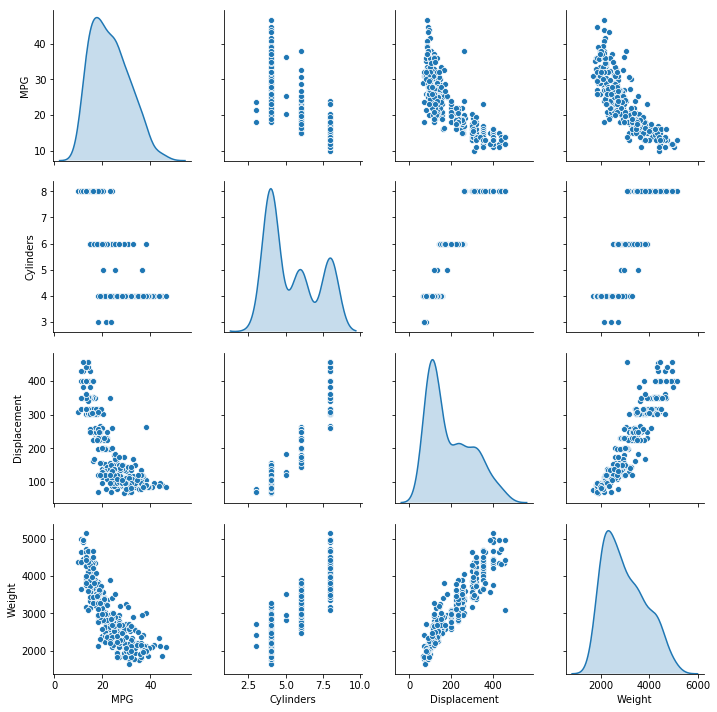

In [39]:
# EDA
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind='kde')

In [40]:
# Look at overall statistics
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horesepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [41]:
# train_dataset

In [42]:
# Separate the target "label" from the features
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

Next we'll normalize the features that use different scales/ranges. The model *might* still converge without feature normalization, though it's good practice to do so and training will be more difficult without it.

In [44]:
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [52]:
normed_train_data[:2]

,Cylinders,Displacement,Horesepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225


## Modeling

In [55]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=["mean_absolute_error", "mean_squared_error"]
                 )
    
    return model

In [56]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Test model to see if output format is correct
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.06899318],
       [0.25547335],
       [0.04806443],
       [0.3396454 ],
       [0.3341306 ],
       [0.18628448],
       [0.38440844],
       [0.4473333 ],
       [0.0561852 ],
       [0.09169638]], dtype=float32)

Training

In [61]:
# Display each epoch as a dot
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
    
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()]
)

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

## Eval

In [62]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,3.410546,1.196681,3.410546,8.617779,2.335365,8.617779,995
996,3.117720,1.115057,3.117720,8.805355,2.334213,8.805355,996
997,3.378096,1.210475,3.378096,8.489953,2.306430,8.489952,997
998,3.050915,1.116931,3.050915,8.596818,2.304412,8.596818,998
999,3.232100,1.176474,3.232100,8.546140,2.288842,8.546141,999


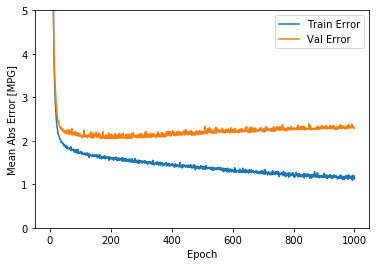

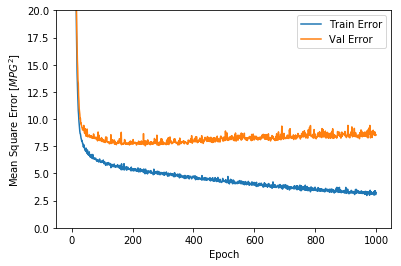

In [63]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


Make predictions

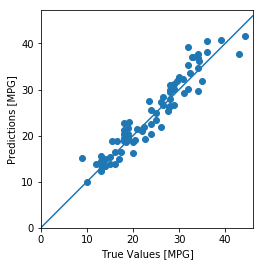

In [64]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

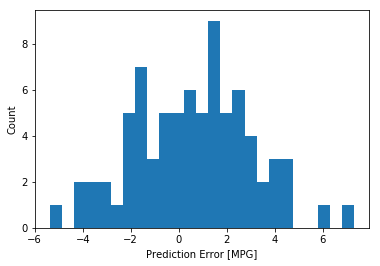

In [66]:
# Error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")